In [2]:
from network_utils_hybrid import *
import random
import numpy as np
import time
import json
import matplotlib.pyplot as plt

In [2]:
num_ToR = 4
n = 4 # must be even, starts from 4
num_bsm_ir = 2
num_bsm_tel = 10
qs_per_node = 10

telecom_gen_rate = 1/(1e-2) # ebit average generation time in sec
switch_duration = 1e-3 # average switching delay in sec

specs = {
    "num_sw_ports": n,
    "num_ToR" : num_ToR,
    "qs_per_node" : qs_per_node,
    "bandwidth" : 2,
    "num_bsm_ir" : num_bsm_ir,
    "num_bsm_tel" : num_bsm_tel,
    "telecom_gen_rate" : telecom_gen_rate,
    "switch_duration" : switch_duration,
    "num_pd" : 1, # inactive
    "num_laser" : 1, # inactive
    "num_bs" : 1, # inactive
    "num_es" : 1 # inactive
}

JSON_PATH = "data/nir_latency.json"
with open(JSON_PATH) as f:
    time_nir = np.array(json.load(f))

telecom_gen_rate = 1/(1e-2) # ebit average generation time in sec
switch_duration = 1e-3 # average switching delay in sec
nir_prob = 1e-2 # NIR gen prob
qubit_reset = 1e-6 # qubit reset time in sec

G, vertex_list = clos_hybrid(specs)
edge_switches, node_list, node_qubit_list =  vertex_list
num_network_qubits = len(node_qubit_list)
print(num_network_qubits)
# num_qubits = 40



160


# Development edition

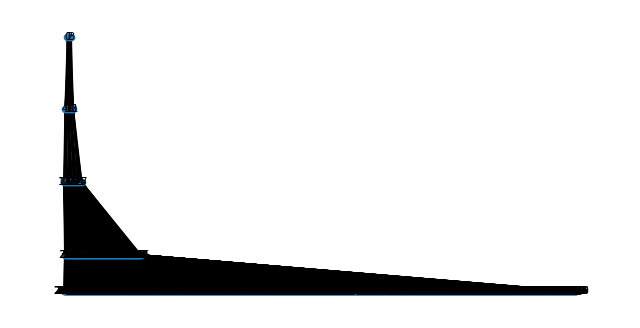

In [97]:
n = 8 # starts from 4
bandwidth = 2
num_ToR = 8
qs_per_node = 10
num_core = n // 2
num_agg = n
num_edge = n**2 // 4
num_nodes = num_edge * num_ToR # number of q nodes
# num_bsms = num_leaves # number of BSMs

# num_bsm = 1
num_bsm_agg = 2
num_bsm_edge = 2
num_pd = 1
num_laser = 1
num_bs = 1
num_es = 1

num_vertices = num_core + num_agg + num_edge + num_nodes
core_bw = 4*bandwidth
agg_bw = 2*bandwidth
edge_bw = bandwidth

G = nx.Graph()
## adding node attributes
# "PD", "BSM", "Laser", "BS", "ES"
attrs = {}

core_switches = range(num_core)
G.add_nodes_from(core_switches, type='core')
for core in core_switches:
    attrs[core] = {"PD": 0, "BSM_ir":0, "BSM_tel":0, "Laser":0, "BS":0, "ES":0}
agg_switches = range(num_core,num_core+num_agg)
G.add_nodes_from(agg_switches, type='agg')
for agg in agg_switches:
    attrs[agg] = {"PD": 0, "BSM_ir":0, "BSM_tel":num_bsm_agg, "Laser":0, "BS":0, "ES":0}
edge_switches = range(num_core+num_agg,num_core + num_agg + num_edge)
G.add_nodes_from(edge_switches, type='edge')
for edge in edge_switches:
    attrs[edge] = {"PD": num_pd, "BSM_ir": num_bsm_edge, "BSM_tel":0, "Laser": num_laser, "BS": num_bs, "ES": num_es}
node_list = range(num_core + num_agg + num_edge,num_vertices)
G.add_nodes_from(node_list, type='node')
node_qubit_list = []
for node in node_list:
    for qubit in range(qs_per_node):
        qname = f"{node},{qubit}"
        node_qubit_list.append(qname)
        G.add_edge(node,qname, weight=1)
        
nx.set_node_attributes(G, attrs)

# G.add_nodes_from(node_qubit_list, type='qubit')

for core in core_switches:
    for agg in agg_switches:
        G.add_edge(core,agg, weight=core_bw)

new_edges = []
extra_edges = []
agg_conn = np.ones(num_agg)* (n//2)
for i, edge in enumerate(edge_switches):
    i1 = np.argwhere(agg_conn>0)[0,0]
    G.add_edge(edge,agg_switches[i1], weight=agg_bw)
    agg_conn[i1] -= 1 
    G.add_edge(edge,agg_switches[i1+1], weight=agg_bw)
    agg_conn[i1+1] -= 1 

for i, edge in enumerate(edge_switches):
    for j in range(num_ToR):
        G.add_edge(edge,node_list[num_ToR*i+j], weight=edge_bw)

shift = 3
pos_core = {i: (shift+i+ n/4 ,2) for i in core_switches}
pos_agg = {i: (shift+(i-n//2)% n,1) for i in agg_switches}
pos_edge = {i: (shift+i-7*n/4+1,0) for i in edge_switches}
pos_nodes = {node: (shift+i/2-1/4,-1) for i, node in enumerate(node_list)}
# pos_qs = {q: (i-2,-1.5-(i%4)/4) for i, q in enumerate(node_qubit_list)}
pos_qs = {q: (i/3+2,-1.5) for i, q in enumerate(node_qubit_list)}
# pos_core = {i: (8*shift+16*i ,2) for i in core_switches}
# pos_agg = {i: (8*shift+16*(((i-n//2)% n)-1),1) for i in agg_switches}
# pos_edge = {i: (0*shift+16*(i-1.2*n),0) for i in edge_switches}
# pos_nodes = {node: (shift+8*i-n,-1) for i, node in enumerate(node_list)}
# pos_qs = {q: (2*i-2,-1.5-(i%4)/4) for i, q in enumerate(node_qubit_list)}
pos = pos_core | pos_agg | pos_edge | pos_nodes | pos_qs


fig, ax = plt.subplots(figsize=(8,4))

nx.draw(G, pos, node_size=20, font_size=7, with_labels=True)
plt.show()

In [4]:
def poisson_random_process(lmbda, total_time):
    """
    Generate a Poisson random process.
    
    Parameters:
        lmbda (float): The parameter lambda of the Poisson distribution.
        total_time (float): The total time for the process.
    
    Returns:
        numpy.ndarray: An array of timestamps when events occur.
    """
    num_events = np.random.poisson(lmbda * total_time)
    event_times = np.cumsum(np.random.exponential(1 / lmbda, num_events))
    event_times = event_times[event_times < total_time]
    return event_times-event_times[0]


def construct_dag(node_qubit_list, q_assignment, num_gates):
    node_qubit_names = [node_qubit_list[q] for q in q_assignment]
    # print(node_qubit_names)
    qubit_nx_to_qiskit = {qubit: idx for idx, qubit in enumerate(node_qubit_names)}
    num_qubits = len(q_assignment)
    connections = []
    for i in range(num_qubits):
        for j in range(i+1,num_qubits):
            if np.random.rand() > 0.5:
                connections.append((node_qubit_names[i],node_qubit_names[j]))
            else:
                connections.append((node_qubit_names[j],node_qubit_names[i]))

    gate_seq = random.choices(connections, k=num_gates)
    qiskit_q_list = QuantumRegister(num_qubits, "q")
    circ = QuantumCircuit(qiskit_q_list)
    for g in gate_seq:
        q1 = qubit_nx_to_qiskit[g[0]]
        q2 = qubit_nx_to_qiskit[g[1]]
        circ.cx(q1,q2)
    dag = circuit_to_dag(circ)
    circ_depth = dag.depth()
    dag_qubit_map = {bit: index for index, bit in enumerate(dag.qubits)}
    # print(gate_seq)
    # print(circ)
    return dag, circ_depth, dag_qubit_map

JSON_PATH = "data/nir_latency.json"
with open(JSON_PATH) as f:
    time_nir = np.array(json.load(f))
    # print(time_nir)


In [61]:
a = [0,1,4,3,2]
print(a[:1])
# # # for x in a[:2]: a.remove(x) 
# # a = sorted(a)
# # print(max(a))
# sample = {0: [1,2], 1:[23,41]}
# for i, j  in sample.items():
#     print(i)
#     print(j)

[0]


In [91]:
telecom_gen_rate = 1/(1e-2) # ebit average generation time in sec
switch_duration = 1e-3 # average switching delay in sec
nir_prob = 1e-2 # NIR gen prob
qubit_reset = 1e-6 # qubit reset time in sec

req_rate = .20
total_time = 500
arrival_times = poisson_random_process(req_rate,total_time)
# print(arrival_times)
num_jobs = len(arrival_times)
print(num_jobs)
qpu_vals = [2,3,4,5,6]
qpu_reqs = np.random.choice(qpu_vals, num_jobs)

start_finish_times = np.zeros((num_jobs,2))
start_finish_times[:,1] = -1

avail_qpus = list(range(n**2//4 * num_ToR))
arrival_times_iter = arrival_times.copy()
qpu_reqs_iter = qpu_reqs.copy()
idx_remain_to_exec = list(range(num_jobs))

dags_list = {}
circ_depth_list = {}
dags_qubit_map = {}
compute_qs_list = {}
qpu_assign = {}
active_jobs = []

remain_gates = np.array([])
tic = 0.0

while len(dags_list)< num_jobs or remain_gates.sum()>0:

    idx_to_exec = np.argwhere(arrival_times_iter<=tic)
    if len(idx_to_exec)>0:
        # print("----------------------")
        # print(f"time: {tic}")
        # print("remain jobs: ", idx_remain_to_exec)
        # print("avail qpus:", avail_qpus)
        idx_to_exec = idx_to_exec[:,0]
        # print("reqs:", arrival_times_iter[idx_to_exec], np.array(qpu_reqs_iter)[idx_to_exec])
        # print("queued:", np.array(idx_remain_to_exec)[idx_to_exec], np.array(qpu_reqs_iter)[idx_to_exec])
        counter = 0
        idx_exec = []
        while len(avail_qpus)>0 and counter<len(idx_to_exec):
            num_req_qpu = qpu_reqs_iter[idx_to_exec[counter]]
            if len(avail_qpus)>= num_req_qpu:
                idx_exec.append(idx_to_exec[counter])
                start_finish_times[idx_remain_to_exec[idx_to_exec[counter]],0] = tic
                start_finish_times[idx_remain_to_exec[idx_to_exec[counter]],1] = 0
                # start_finish_times[num_jobs-len(arrival_times_iter)+counter,2] = avail_qpus[0]
                qpu_list = avail_qpus[:num_req_qpu]
                qpu_assign[idx_remain_to_exec[idx_to_exec[counter]]] = qpu_list
                compute_qs = [qs_per_node*j + i  for j in qpu_list for i in range(qs_per_node)]
                num_gates = 10*len(compute_qs)
                dag, circ_depth, dag_qubit_map = construct_dag(node_qubit_list, compute_qs, num_gates)
                dags_list[idx_remain_to_exec[idx_to_exec[counter]]] = dag
                compute_qs_list[idx_remain_to_exec[idx_to_exec[counter]]] = compute_qs
                circ_depth_list[idx_remain_to_exec[idx_to_exec[counter]]] = circ_depth
                dags_qubit_map[idx_remain_to_exec[idx_to_exec[counter]]] = dag_qubit_map # don't forget to remove it.
                for q1 in qpu_list:
                    avail_qpus.remove(q1)
                active_jobs.append(idx_remain_to_exec[idx_to_exec[counter]])

            counter += 1
        # print("executed:", arrival_times_iter[idx_exec])
        # print("executed:",  np.array(idx_remain_to_exec)[idx_exec])
        arrival_times_iter = np.delete(arrival_times_iter, idx_exec)
        idx_remain_to_exec = np.delete(idx_remain_to_exec, idx_exec)
        qpu_reqs_iter = np.delete(qpu_reqs_iter, idx_exec)

    num_active_jobs = len(dags_list)
    G_ins =  G.copy()
    num_ir_swap = 0
    num_tel_swap = 0
    execute = True
    while execute:
        execute = False

        indep_gate_seq_list = {}
        dag_node_seq_list = {}
        for i_dag, dag in dags_list.items():
            dag_qubit_map = dags_qubit_map[i_dag]
            compute_qs = compute_qs_list[i_dag]
            indep_gate_seq = []
            dag_node_seq = []
            num_decendants = []
            for node in dag.front_layer():
                if node.op.num_qubits< 2:
                    dag.remove_op_node(node)
                if node.op.num_qubits>= 2:
                    indep_gate_seq.append((node_qubit_list[compute_qs[dag_qubit_map[node.qargs[0]]]],node_qubit_list[compute_qs[dag_qubit_map[node.qargs[1]]]]))
                    dag_node_seq.append(node)
                    num_decendants.append(len([g for g in dag.bfs_successors(node)])-1)

            sorted_idx = sorted(range(len(num_decendants)), key=lambda k: num_decendants[k], reverse=True)
            # sorted_idx = sorted(range(len(num_decendants)), key=lambda x: random.random())
            dag_node_seq = [dag_node_seq[k] for k in sorted_idx]
            indep_gate_seq = [indep_gate_seq[k] for k in sorted_idx]
            indep_gate_seq_list[i_dag] = indep_gate_seq
            dag_node_seq_list[i_dag] = dag_node_seq

        rand_idx = sorted(active_jobs, key=lambda x: random.random())
        for i_job in rand_idx:
            indep_gate_seq = indep_gate_seq_list[i_job]
            # for i_g, g in enumerate(indep_gate_seq):
            for i_g, g in enumerate(indep_gate_seq[:1]):
                n0 = g[0]
                n1 = g[1]
                if nx.has_path(G_ins,n0,n1):
                    paths = nx.all_shortest_paths(G_ins, n0, n1, weight=None)
                    for shortestpath in paths:
                        if len(shortestpath)<= 3 :
                            dags_list[i_job].remove_op_node(dag_node_seq_list[i_job][i_g])
                            execute = True
                            break
                        elif len(shortestpath)> 5 :
                            tel_ir = "tel"
                        else:
                            tel_ir = "ir"

                        sp = []
                        b = []
                        # for i in range(0,len(shortestpath)-1):
                        for i in range(1,len(shortestpath)-2):
                            sp.append((shortestpath[i],shortestpath[i+1]))
                            if 1 < i < len(shortestpath)-2:
                                sw = shortestpath[i]
                                if G_ins.nodes[sw]["BSM_"+tel_ir] > 0:
                                    b.append(sw)
                        
                        if len(b)>=1:
                            sw_bsm = random.sample(b,1)[0]
                            G_ins.nodes[sw_bsm]["BSM_"+tel_ir]-= 1
                            for u, v in sp:
                                if G_ins[u][v]['weight'] == 1:
                                    G_ins.remove_edge(u, v)
                                else:
                                    G_ins[u][v]['weight'] -= 1
                            if  tel_ir == "tel":
                                num_tel_swap += 1
                            else:
                                num_ir_swap += 1
                            
                            dags_list[i_job].remove_op_node(dag_node_seq_list[i_job][i_g])
                            execute = True
                            break
    t_tel = 1/telecom_gen_rate * time_spdc([num_tel_swap])[0]
    t_nir = qubit_reset * time_nir[num_ir_swap]
    dt = max([t_tel,t_nir]) + switch_duration * ( (num_tel_swap + num_ir_swap) > 0 )
    if dt > 0:
        tic += dt
    else:
        if len(arrival_times_iter)>0:
            tic = arrival_times_iter[0]
            
    if len(dags_list) > 0:
        remain_gates = np.ones(num_jobs)
        for i_rem in dags_list.keys():
            remain_gates[i_rem] = len(dags_list[i_rem].gate_nodes())
        # remain_gates = np.array([len(dag.gate_nodes()) for dag in dags_list.values()])
        done_jobs = np.argwhere(remain_gates==0)
        if len(done_jobs)>0:
            done_jobs = done_jobs[:,0]
            for i_jobs in done_jobs:
                if start_finish_times[i_jobs,1] == 0:
                    print(f"{i_jobs} is done at {tic}")
                    start_finish_times[i_jobs,1] = tic
                    active_jobs.remove(i_jobs)
                    # avail_qpus += [int(start_finish_times[i_jobs,2])]
                    avail_qpus += qpu_assign[i_jobs]
            avail_qpus = sorted(avail_qpus)

print("Queue is done!")

74
0 is done at 2.745040736873338
1 is done at 3.854973044582009
2 is done at 11.081345141215218
3 is done at 26.128167746263912
4 is done at 27.19834823086122
5 is done at 32.24731218731327
6 is done at 39.550821328214106
7 is done at 41.17974773756027
8 is done at 43.13937979160674
9 is done at 54.53964153913658
10 is done at 64.10466403416139
11 is done at 67.64331482876527
12 is done at 69.64768225510686
13 is done at 78.15882413170124
14 is done at 91.2175204158115
15 is done at 91.43455373934405
16 is done at 93.85740722283359
18 is done at 102.02777693392942
17 is done at 102.18444360059608
19 is done at 103.09440933874221
20 is done at 115.48832626912555
21 is done at 130.0346704417597
22 is done at 133.49581014878385
23 is done at 143.85826971732163
24 is done at 150.26482274731126
25 is done at 150.5552927330663
26 is done at 157.86411806647232
27 is done at 175.03323101246232
28 is done at 179.90861680314265
29 is done at 186.2459026995516
30 is done at 186.81882218081662
31

In [72]:
print(start_finish_times[:,0])
print(start_finish_times[:,1]-start_finish_times[:,0])
# print(start_finish_times[:,0]-arrival_times)
# print(arrival_times)
print(qpu_reqs)
print(qpu_assign)

[ 0.          0.66784924 20.36911838 24.67945671 34.46330625 40.00421156
 43.57583921 52.50197663]
[20.42945171  2.31846061 15.36586033  0.7965286   7.13784168  4.19174568
  9.58006511  1.53082705]
[6 4 5 2 6 4 3 4]
{0: [0, 1, 2, 3, 4, 5], 1: [6, 7, 8, 9], 2: [6, 7, 8, 9, 10], 3: [0, 1], 4: [0, 1, 2, 3, 4, 5], 5: [6, 7, 8, 9], 6: [0, 1, 2], 7: [3, 4, 5, 6]}


In [75]:
print(start_finish_times[:,0])
print(start_finish_times[:,1]-start_finish_times[:,0])
# print(start_finish_times[:,0]-arrival_times)
# print(arrival_times)
print(qpu_reqs)
print(qpu_assign)

[ 0.          0.677      20.36911838 24.67945671 34.46330625 40.00421156
 43.57583921 52.50197663]
[2.29963095 1.88381392 1.51494937 0.06094743 1.88404901 0.17594257
 0.11839501 0.15754335]
[6 4 5 2 6 4 3 4]
{0: [0, 1, 2, 3, 4, 5], 1: [6, 7, 8, 9], 2: [0, 1, 2, 3, 4], 3: [0, 1], 4: [0, 1, 2, 3, 4, 5], 5: [0, 1, 2, 3], 6: [0, 1, 2], 7: [0, 1, 2, 3]}


[12, 15, 12, 19, 16]


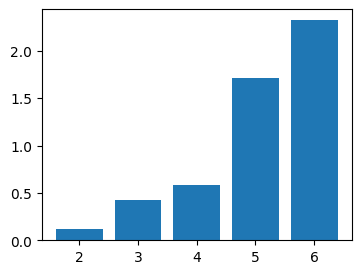

In [92]:
compute_time_list = {}
for qpu in qpu_vals:
    compute_time_list[qpu] = []

for i_job in range(num_jobs):
    compute_time_list[qpu_reqs[i_job]].append(start_finish_times[i_job,1]-start_finish_times[i_job,0]) 

# print(compute_time_list)
qpu_list = []
qpu_time = []
qpu_list_num = []
for qpu in compute_time_list.keys():
    if len(compute_time_list[qpu])>0:
        qpu_list_num.append(len(compute_time_list[qpu]))
        qpu_list.append(qpu)
        qpu_time.append(sum(compute_time_list[qpu])/len(compute_time_list[qpu]))

print(qpu_list_num)
plt.figure(figsize=(4,3))
plt.bar(qpu_list,qpu_time)#,".-")
plt.show()

[19, 14, 20, 22, 19]


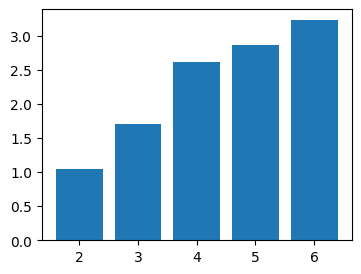

In [90]:
compute_time_list = {}
for qpu in qpu_vals:
    compute_time_list[qpu] = []

for i_job in range(num_jobs):
    compute_time_list[qpu_reqs[i_job]].append(start_finish_times[i_job,1]-start_finish_times[i_job,0]) 

# print(compute_time_list)
qpu_list = []
qpu_time = []
qpu_list_num = []
for qpu in compute_time_list.keys():
    if len(compute_time_list[qpu])>0:
        qpu_list_num.append(len(compute_time_list[qpu]))
        qpu_list.append(qpu)
        qpu_time.append(sum(compute_time_list[qpu])/len(compute_time_list[qpu]))

print(qpu_list_num)
plt.figure(figsize=(4,3))
plt.bar(qpu_list,qpu_time)#,".-")
plt.show()

[8, 11, 14, 12, 8]


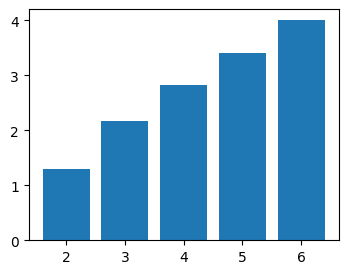

In [88]:
compute_time_list = {}
for qpu in qpu_vals:
    compute_time_list[qpu] = []

for i_job in range(num_jobs):
    compute_time_list[qpu_reqs[i_job]].append(start_finish_times[i_job,1]-start_finish_times[i_job,0]) 

# print(compute_time_list)
qpu_list = []
qpu_time = []
qpu_list_num = []
for qpu in compute_time_list.keys():
    if len(compute_time_list[qpu])>0:
        qpu_list_num.append(len(compute_time_list[qpu]))
        qpu_list.append(qpu)
        qpu_time.append(sum(compute_time_list[qpu])/len(compute_time_list[qpu]))

print(qpu_list_num)
plt.figure(figsize=(4,3))
plt.bar(qpu_list,qpu_time)#,".-")
plt.show()

In [115]:
Niter = 10
qpu_vals = [64,16,4]
req_rate_list = 10**np.array([-1.0,0.0,1.0]) #np.logspace(-2,1.0,10)

arrival_times_list = []
qpu_reqs_list = []
total_time = Niter/min(req_rate_list)
for i_req, req_rate in enumerate(req_rate_list):
    arrival_times = poisson_random_process(req_rate,total_time)
    num_jobs = len(arrival_times) - 1
    arrival_times_list += arrival_times[1:].tolist()
    qpu_reqs_list += [qpu_vals[i_req]]*num_jobs

sorted_idx = sorted(range(len(arrival_times_list)), key=lambda k: arrival_times_list[k])
arrival_times_list = [arrival_times_list[k] for k in sorted_idx]
qpu_reqs_list = [qpu_reqs_list[k] for k in sorted_idx]

print(arrival_times_list, len(arrival_times_list))
print(qpu_reqs_list, len(qpu_reqs_list))

print(len(arrival_times_list),len(qpu_reqs_list))


[0.034747594012280024, 0.0643199747353537, 0.0643646914409612, 0.08928211116964908, 0.1014106381290037, 0.28738173280267365, 0.40384236346039254, 0.4963171637518017, 0.5561646644543994, 0.7024613513013354, 1.0158871071951612, 1.0939531921180556, 1.2648424071975468, 1.2791568020121367, 1.3926129502351987, 1.408283627440743, 1.4862396744180741, 1.5216188784391915, 1.6158579658384506, 1.6617471752140907, 1.7197042069968493, 1.7814758473174717, 1.819408188395995, 1.829806888070345, 1.8302721251276226, 1.8611309101714382, 1.954623828072497, 2.073679461430284, 2.129370300865215, 2.214096361152144, 2.260460326286943, 2.311159901517177, 2.4983007597457574, 2.5228251073748864, 2.771773309757792, 2.7722143360841143, 2.844088654622892, 2.850613608788121, 2.8993521547985486, 2.913197575173538, 2.9424167752419015, 3.1081159614464164, 3.183726468875019, 3.241955769450318, 3.301467143729134, 3.3047553454190672, 3.352128783501952, 3.416129910993633, 3.509671783519958, 3.5139868662967384, 3.61166644293

In [74]:

num_net_nodes = len(node_list)
num_net_edge = len(edge_switches)
num_net_qubits = len(node_qubit_list)

req_rate = 0.1
total_time = 101
job_time = 11
arrival_times = poisson_random_process(req_rate,total_time)
print(arrival_times)
num_jobs = len(arrival_times)
start_finish_times = np.zeros((num_jobs,3))
start_finish_times[:,1] = -1
print(f"No. of jobs: {num_jobs}")

avail_qpus = list(range(num_ToR))
switch_events = np.arange(0,total_time,10)
arrival_times_iter = arrival_times.copy()
for tic in switch_events:
    print(f"time: {tic}")
    running_idx = np.argwhere(start_finish_times[:,1]==0)
    if len(running_idx)>0:
        running_idx = running_idx[:,0]
        done_jobs = np.argwhere(tic-start_finish_times[running_idx,0] > job_time)
        if len(done_jobs)>0:
            done_jobs = done_jobs[:,0]
            start_finish_times[running_idx[done_jobs],1] = tic
            avail_qpus += start_finish_times[running_idx[done_jobs],2].astype(int).tolist()

    idx_to_exec = np.argwhere(arrival_times_iter<=tic)
    if len(idx_to_exec)>0:
        print("avail qpus:", avail_qpus)
        idx_to_exec = idx_to_exec[:,0]
        print("reqs:", arrival_times_iter[idx_to_exec])
        counter = 0
        idx_exec = []
        while len(avail_qpus)>0 and counter<len(idx_to_exec):
            idx_exec.append(idx_to_exec[counter])
            start_finish_times[num_jobs-len(arrival_times_iter)+counter,0] = tic
            start_finish_times[num_jobs-len(arrival_times_iter)+counter,1] = 0
            start_finish_times[num_jobs-len(arrival_times_iter)+counter,2] = avail_qpus[0]
            compute_q_list = [qs_per_node*num_ToR*j + i + qs_per_node*avail_qpus[0]  for j in range(n**2//4) for i in range(qs_per_node)]
            num_gates = len(compute_q_list)
            dag, circ_depth, dag_qubit_map = construct_dag(compute_q_list, num_gates)
            dags_list.append(dag)
            circ_depth_list.append(circ_depth)
            dags_qubit_map.append(dag_qubit_map) # don't forget to remove it.
            avail_qpus.remove(avail_qpus[0])
            counter += 1
        print("executed:", arrival_times_iter[idx_exec])
        arrival_times_iter = np.delete(arrival_times_iter, idx_exec)

print("sf times", start_finish_times)
print("circ depths", circ_depth_list)
    # arrival_times_iter[]  
# num_gates = 4
# # print(compute_q_list)
# compute_q_list = []
# for job_num in range(num_ToR):
# # for job_num in range(1):
#     compute_q_list.append([qs_per_node*num_ToR*j + i + qs_per_node*job_num  for j in range(n**2//4) for i in range(qs_per_node)])
#     print(compute_q_list[job_num])
#     dag, circ_depth, dag_qubit_map = construct_dag(compute_q_list[job_num], num_gates)
#     # dag_drawer(dag)
#     # print(dag)
# # dag_drawer(dag)

# # dags_list.append(dag)
# # circ_depth_list.append(circ_depth)
# # dag_qubit_map_list.append(dag_qubit_map)

[0.53840476 0.58532143 1.43710714 0.92989286 1.15532143 1.15532143
 1.38075    0.90171429 1.23985714 0.98625    1.32439286 1.09896429
 0.789      0.95807143 0.90171429 1.01008333 0.87353571 0.84545238]
[0.         0.02081869 0.02031822 0.01228744 0.01593441 0.18116814
 0.34401299 0.49489368 0.67143987 0.81040865 0.46511381 0.88059624
 0.64693339 1.12804837 1.20102455 1.2086485  1.22581676 1.41246504]


In [42]:
compute_q_list = []
for n in range(num_ToR):
    compute_q_list.append([10*num_ToR*j + i + 10*n  for j in range(4) for i in range(10)])
print(compute_q_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159]]


In [37]:
# compute_q_list = [10*num_ToR*j + i  for j in range(4) for i in range(10)]
compute_q_list = [10*num_ToR*j + i  for j in range(4) for i in range(20)]
# print(compute_q_list)
connections = []
for i in range(num_qubits):
    for j in range(i+1,num_qubits):
        if np.random.rand() > 0.5:
            connections.append((node_qubit_list[compute_q_list[i]],node_qubit_list[compute_q_list[j]]))
        else:
            connections.append((node_qubit_list[compute_q_list[j]],node_qubit_list[compute_q_list[i]]))

num_gates_list = np.linspace(num_qubits,8*num_qubits,10)
# num_gates = 4 * num_qubits
latency_depth_list = []
for num_gates in num_gates_list:
    num_gates = int(num_gates)
    print(num_gates)
    tic = time.time()
    latency_depth = []
    for _ in range(Nrep):

        gate_seq = random.choices(connections, k=num_gates)
        switch_seq, circ_depth = eff_network_latency_dag_multiqubit_hybrid(G, vertex_list, gate_seq)
        switch_seq = np.array(switch_seq)

        tel_latency = 1/telecom_gen_rate * time_spdc(switch_seq[:,1]) 
        nir_latency = qubit_reset * np.array([time_nir[k] for k in switch_seq[:,0]])
        latency_combined = np.stack((tel_latency,nir_latency), axis = 1)

        T_latency =  np.max(latency_combined, axis = 1).sum() + switch_duration * switch_seq.shape[0] 
        latency_depth_list.append([num_gates,circ_depth, T_latency])
        
    toc = time.time()    
    print(f"elapsed time {toc-tic} sec")
latency_depth_list = np.array(latency_depth_list)


80
elapsed time 0.301389217376709 sec
142
elapsed time 0.5286040306091309 sec
204
elapsed time 0.8711047172546387 sec
266
elapsed time 1.152573585510254 sec
328
elapsed time 1.5199968814849854 sec
391
elapsed time 2.0622880458831787 sec
453
elapsed time 2.5161097049713135 sec
515
elapsed time 3.188742160797119 sec
577
elapsed time 3.82106876373291 sec
640
elapsed time 4.51190972328186 sec


/tmp/ipykernel_1302775/216168647.py:27: RuntimeWarning: invalid value encountered in scalar divide
  latency_std_g[i_c] =  latency_list_g[idx].std()/np.sqrt(idx.shape[0]-1)
/tmp/ipykernel_1302775/216168647.py:48: RuntimeWarning: invalid value encountered in scalar divide
  latency_std[i_c] =  latency_list[idx].std()/np.sqrt(idx.shape[0]-1)


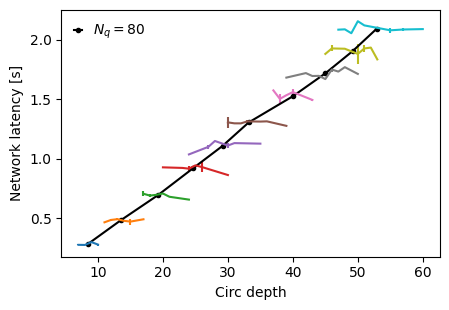

In [39]:
# y_color = np.linspace(0,1,len(num_qubits_list))
# colors_bar = plt.cm.viridis_r(y_color)

num_qubits_list = [len(compute_q_list)]

plt.figure(figsize=(4.6,3.2))
for i_n, num_qubits in enumerate(num_qubits_list):

    num_g_list = latency_depth_list[:,0].tolist()
    depth_list = latency_depth_list[:,1].tolist()
    latency_list = latency_depth_list[:,2].tolist()

    if len(depth_list)>0:
        latency_avg_list = []
        depth_avg_list = []
        for num_gates in num_gates_list:
            num_gates = int(num_gates) + 0.0
            idx_g = np.argwhere(np.array(num_g_list)==num_gates)[:,0]
            depth_list_g = np.array(depth_list)[idx_g]
            latency_list_g = np.array(latency_list)[idx_g]      
            depth_vals_g = sorted(list(set(depth_list_g.tolist())))
            latency_avg_g = np.zeros(len(depth_vals_g))
            latency_std_g = np.zeros(len(depth_vals_g))
            for i_c, circ_depth in enumerate(depth_vals_g):
                idx = np.argwhere(depth_list_g==circ_depth)[:,0]
                latency_avg_g[i_c] =  latency_list_g[idx].mean()
                latency_std_g[i_c] =  latency_list_g[idx].std()/np.sqrt(idx.shape[0]-1)
        # # plt.plot(depth_vals, latency_avg, color= colors_bar[i_n,:],label=rf"$N_q=${num_qubits}")
            plt.errorbar(depth_vals_g, latency_avg_g,latency_std_g)#,label=rf"$N_q=${num_qubits}")
            # plt.title(rf"$N_q=${num_qubits}")
            # plt.ylim(0.2,0.5)
            # plt.xlim(5,22)
            plt.xlabel("Circ depth")
            plt.ylabel("Network latency [s]")
            plt.tight_layout()
            latency_avg_list.append(latency_list_g.mean())
            depth_avg_list.append(depth_list_g.mean())
        # plt.plot(depth_avg_list, latency_avg_list, ".-", color= colors_bar[i_n,:],label=rf"$N_q=${num_qubits}")
        plt.plot(depth_avg_list, latency_avg_list, "k.-",label=rf"$N_q=${num_qubits}")
        depth_vals = sorted(list(set(depth_list)))
        depth_list = np.array(depth_list)
        latency_list = np.array(latency_list)
        latency_avg = np.zeros(len(depth_vals))
        latency_std = np.zeros(len(depth_vals))
        for i_c, circ_depth in enumerate(depth_vals):
            idx = np.argwhere(depth_list==circ_depth)[:,0]
            latency_avg[i_c] =  latency_list[idx].mean()
            latency_std[i_c] =  latency_list[idx].std()/np.sqrt(idx.shape[0]-1)

        # plt.plot(depth_vals, latency_avg, color= colors_bar[i_n,:],label=rf"$N_q=${num_qubits}")
        # plt.errorbar(depth_vals, latency_avg,latency_std, color= "black",label=rf"$N_q=${num_qubits}")

# plt.ylim(0,22)
# plt.xlim(0,240)
plt.legend(handlelength=0.6, frameon=False)
# plt.title("new algo")
plt.show()



In [35]:
# compute_q_list = [10*num_ToR*j + i  for j in range(4) for i in range(10)]
compute_q_list = list(range(80))
# print(compute_q_list)
connections = []
for i in range(num_qubits):
    for j in range(i+1,num_qubits):
        if np.random.rand() > 0.5:
            connections.append((node_qubit_list[compute_q_list[i]],node_qubit_list[compute_q_list[j]]))
        else:
            connections.append((node_qubit_list[compute_q_list[j]],node_qubit_list[compute_q_list[i]]))

num_gates_list = np.linspace(num_qubits,8*num_qubits,10)
# num_gates = 4 * num_qubits
latency_depth_list2 = []
for num_gates in num_gates_list:
    num_gates = int(num_gates)
    print(num_gates)
    tic = time.time()
    latency_depth = []
    for _ in range(Nrep):

        gate_seq = random.choices(connections, k=num_gates)
        switch_seq, circ_depth = eff_network_latency_dag_multiqubit_hybrid(G, vertex_list, gate_seq)
        switch_seq = np.array(switch_seq)

        tel_latency = 1/telecom_gen_rate * time_spdc(switch_seq[:,1]) 
        nir_latency = qubit_reset * np.array([time_nir[k] for k in switch_seq[:,0]])
        latency_combined = np.stack((tel_latency,nir_latency), axis = 1)

        T_latency =  np.max(latency_combined, axis = 1).sum() + switch_duration * switch_seq.shape[0] 
        latency_depth_list2.append([num_gates,circ_depth, T_latency])
        
    toc = time.time()    
    print(f"elapsed time {toc-tic} sec")
latency_depth_list2 = np.array(latency_depth_list2)


80
elapsed time 0.3909904956817627 sec
142
elapsed time 0.5837054252624512 sec
204
elapsed time 0.8999874591827393 sec
266
elapsed time 1.2233474254608154 sec
328
elapsed time 1.7183334827423096 sec
391
elapsed time 2.133702278137207 sec
453
elapsed time 2.777132749557495 sec
515
elapsed time 3.423358917236328 sec
577
elapsed time 4.159504652023315 sec
640
elapsed time 4.917202472686768 sec


/tmp/ipykernel_1302775/293751828.py:27: RuntimeWarning: invalid value encountered in scalar divide
  latency_std_g[i_c] =  latency_list_g[idx].std()/np.sqrt(idx.shape[0]-1)
/tmp/ipykernel_1302775/293751828.py:48: RuntimeWarning: invalid value encountered in scalar divide
  latency_std[i_c] =  latency_list[idx].std()/np.sqrt(idx.shape[0]-1)


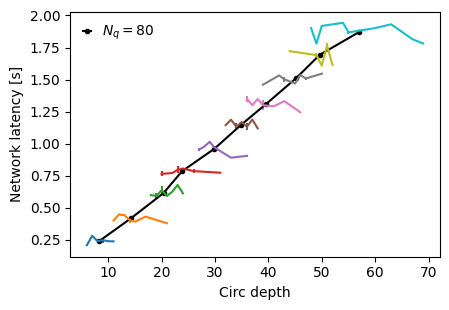

In [36]:
# y_color = np.linspace(0,1,len(num_qubits_list))
# colors_bar = plt.cm.viridis_r(y_color)

num_qubits_list = [len(compute_q_list)]

plt.figure(figsize=(4.6,3.2))
for i_n, num_qubits in enumerate(num_qubits_list):

    num_g_list = latency_depth_list2[:,0].tolist()
    depth_list = latency_depth_list2[:,1].tolist()
    latency_list = latency_depth_list2[:,2].tolist()

    if len(depth_list)>0:
        latency_avg_list = []
        depth_avg_list = []
        for num_gates in num_gates_list:
            num_gates = int(num_gates) + 0.0
            idx_g = np.argwhere(np.array(num_g_list)==num_gates)[:,0]
            depth_list_g = np.array(depth_list)[idx_g]
            latency_list_g = np.array(latency_list)[idx_g]      
            depth_vals_g = sorted(list(set(depth_list_g.tolist())))
            latency_avg_g = np.zeros(len(depth_vals_g))
            latency_std_g = np.zeros(len(depth_vals_g))
            for i_c, circ_depth in enumerate(depth_vals_g):
                idx = np.argwhere(depth_list_g==circ_depth)[:,0]
                latency_avg_g[i_c] =  latency_list_g[idx].mean()
                latency_std_g[i_c] =  latency_list_g[idx].std()/np.sqrt(idx.shape[0]-1)
        # # plt.plot(depth_vals, latency_avg, color= colors_bar[i_n,:],label=rf"$N_q=${num_qubits}")
            plt.errorbar(depth_vals_g, latency_avg_g,latency_std_g)#,label=rf"$N_q=${num_qubits}")
            # plt.title(rf"$N_q=${num_qubits}")
            # plt.ylim(0.2,0.5)
            # plt.xlim(5,22)
            plt.xlabel("Circ depth")
            plt.ylabel("Network latency [s]")
            plt.tight_layout()
            latency_avg_list.append(latency_list_g.mean())
            depth_avg_list.append(depth_list_g.mean())
        # plt.plot(depth_avg_list, latency_avg_list, ".-", color= colors_bar[i_n,:],label=rf"$N_q=${num_qubits}")
        plt.plot(depth_avg_list, latency_avg_list, "k.-",label=rf"$N_q=${num_qubits}")
        depth_vals = sorted(list(set(depth_list)))
        depth_list = np.array(depth_list)
        latency_list = np.array(latency_list)
        latency_avg = np.zeros(len(depth_vals))
        latency_std = np.zeros(len(depth_vals))
        for i_c, circ_depth in enumerate(depth_vals):
            idx = np.argwhere(depth_list==circ_depth)[:,0]
            latency_avg[i_c] =  latency_list[idx].mean()
            latency_std[i_c] =  latency_list[idx].std()/np.sqrt(idx.shape[0]-1)

        # plt.plot(depth_vals, latency_avg, color= colors_bar[i_n,:],label=rf"$N_q=${num_qubits}")
        # plt.errorbar(depth_vals, latency_avg,latency_std, color= "black",label=rf"$N_q=${num_qubits}")

# plt.ylim(0,22)
# plt.xlim(0,240)
plt.legend(handlelength=0.6, frameon=False)
# plt.title("new algo")
plt.show()

